In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

2024-10-26 14:08:00.421655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 14:08:00.421874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 14:08:00.562844: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
train_dir = 'train_set'
test_dir = 'test_set'

# Create directories for train and test sets if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of classes (sub-folders)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Loop through each class
for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    # Split the images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create class directories in the train and test folders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    
    # Copy training images
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copyfile(src, dst)
    
    # Copy testing images
    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, cls, img)
        shutil.copyfile(src, dst)

In [4]:
image_set =  "/kaggle/working/train_set"
test_set_directory = '/kaggle/working/test_set'

In [5]:
SIZE_X = SIZE_Y = 224

datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.5)

validate_set = test_datagen.flow_from_directory(
       test_set_directory,
       class_mode = "categorical",
       target_size = (SIZE_X, SIZE_Y),
       color_mode="rgb",
       batch_size = 128, 
       shuffle = False,
       subset='training',
       seed = 42)


test_set = test_datagen.flow_from_directory(
    test_set_directory,
    class_mode='categorical',
    target_size=(SIZE_X, SIZE_Y),
    color_mode='rgb',
    batch_size=128,
    subset='validation',
    shuffle=False,  # No shuffling needed for testing
    seed = 42
)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [6]:
IMAGE_SIZE = [224, 224]

In [7]:
batch_size = 128

In [8]:
def loss_curve(history):
    plt.plot(history.history['loss'],label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'testing_loss')
    plt.title('loss')
    plt.legend()
    plt.show()


In [9]:
def accuracy_curve(history):
    plt.plot(history.history['accuracy'], label='training_accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [11]:
def reports(model,test_set):
    from sklearn.metrics import confusion_matrix
    Y_pred = model.predict(test_set)
    y_pred = np.argmax(Y_pred ,axis =1)
    print('Confusion Matrix')
    confusion_matrix = confusion_matrix(test_set.classes, y_pred)
    print(confusion_matrix)
    print('Classification Report')
    target_names = ['aca','n', 'scc']
    print(classification_report(test_set.classes, y_pred, target_names=target_names))

In [12]:
def report_accracy(model, test_set):

    Y_pred = model.predict(test_set)
    y_pred = np.argmax(Y_pred, axis=1)
    
    cm = confusion_matrix(test_set.classes, y_pred)
    report = classification_report(test_set.classes, y_pred, output_dict=True)
    overall_accuracy = report['accuracy']
    
    return overall_accuracy

# VGG16

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Load VGG16 with pre-trained ImageNet weights, exclude top layer
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Set VGG16 layers to non-trainable
for layer in vgg16.layers:
    layer.trainable = False

# Add custom classification layers on top of VGG16
flatten = Flatten()(vgg16.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

# Create the new model
vgg16_model = Model(inputs=vgg16.input, outputs=prediction)

# Print the model summary
vgg16_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,170,755 (80.76 MB)

 Trainable params: 6,456,067 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
batch_size = 128

# VGG16 training

In [15]:
# Compile the VGG16 model
vgg16_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the VGG16 model
history_vgg16 = vgg16_model.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size,
    validation_steps=len(validate_set) // batch_size
)


Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-26 14:10:01.817933: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-10-26 14:10:03.804788: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.47892, expe

 8/94 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.2253 - loss: 230.1733

2024-10-26 14:11:10.454552: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[96,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-10-26 14:11:11.612662: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 2.45336, expected 2.01081
2024-10-26 14:11:11.612735: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 2.78468, expected 2.34212
2024-10-26 14:11:11.612745: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 3.40726, expected 2.96471
2024-10-26 14:11:11.612753: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6378 - loss: 70.1412

W0000 00:00:1729951963.271829     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-10-26 14:12:50.414031: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[92,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[92,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-10-26 14:12:51.492603: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.93093, expected 3.09758
2024-10-26 14:12:51.492657: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.14004, expected 4.30669
2024-10-26 14:12:51.492667: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Dif

94/94 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.6396 - loss: 69.6385 - val_accuracy: 0.7380 - val_loss: 6.3419
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 562ms/step - accuracy: 0.8433 - loss: 3.1061 - val_accuracy: 0.9533 - val_loss: 0.5252
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 542ms/step - accuracy: 0.9665 - loss: 0.2431 - val_accuracy: 0.9747 - val_loss: 0.2402
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 548ms/step - accuracy: 0.9652 - loss: 0.3339 - val_accuracy: 0.9247 - val_loss: 1.0427
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 553ms/step - accuracy: 0.9514 - loss: 0.7394 - val_accuracy: 0.9787 - val_loss: 0.1978


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 495ms/step - accuracy: 0.9722 - loss: 0.1892
Test loss, test accuracy: [0.20798031985759735, 0.968666672706604]


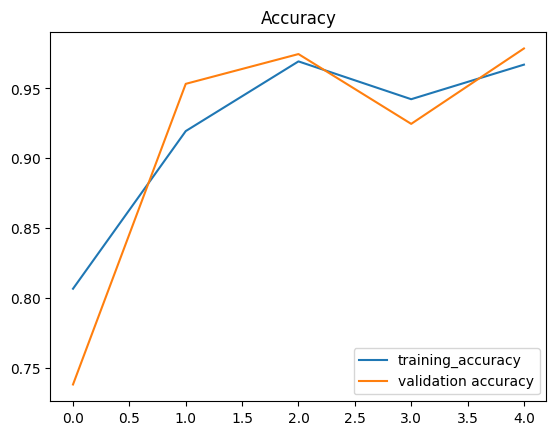

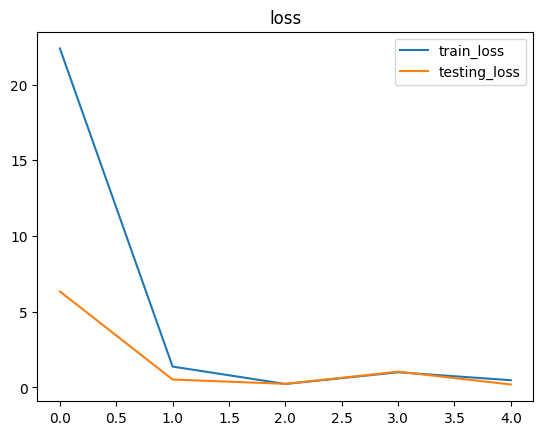

 1/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step

W0000 00:00:1729952248.974588     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 514ms/step
Confusion Matrix
[[483   3  14]
 [  1 499   0]
 [ 29   0 471]]
Classification Report
              precision    recall  f1-score   support

         aca       0.94      0.97      0.95       500
           n       0.99      1.00      1.00       500
         scc       0.97      0.94      0.96       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



In [16]:
# Evaluate the VGG16 model on the test set
result_vgg16 = vgg16_model.evaluate(test_set, batch_size=128)
print("Test loss, test accuracy:", result_vgg16)

# Plot the accuracy and loss curves
accuracy_curve(history_vgg16)
loss_curve(history_vgg16)

# Generate the classification report and confusion matrix
reports(vgg16_model, test_set)


In [17]:
# Calculate accuracy for the VGG16 model on the test set
r_accuracy_vgg16 = report_accracy(vgg16_model, test_set) * 100
formatted_accuracy_vgg16 = f"{r_accuracy_vgg16:.2f}"
print("Formatted Test Accuracy:", formatted_accuracy_vgg16)


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 483ms/step
Formatted Test Accuracy: 96.87


# Model 1

In [18]:
import keras
from tensorflow.keras import layers, models, Input

In [19]:
model_1 = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128,(3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(256,(3, 3), strides=(2, 2), padding="same"),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(3, activation='softmax'),
    ],
)


model_1.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │       150,531 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,931 (2.55 MB)

 Trainable params: 668,931 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras import layers, models, optimizers, losses

In [35]:
model_1.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss=losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

history = model_1.fit(train_set, validation_data=validate_set, epochs=10, verbose=1)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 557ms/step - accuracy: 0.5820 - loss: 802.4860 - val_accuracy: 0.6993 - val_loss: 22.1169
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 533ms/step - accuracy: 0.7281 - loss: 20.4611 - val_accuracy: 0.7020 - val_loss: 10.3529
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 533ms/step - accuracy: 0.8140 - loss: 8.9380 - val_accuracy: 0.8333 - val_loss: 4.8355
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 548ms/step - accuracy: 0.8081 - loss: 5.7031 - val_accuracy: 0.6780 - val_loss: 5.4168
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 53s 528ms/step - accuracy: 0.7228 - loss: 5.3592 - val_accuracy: 0.8207 - val_loss: 2.5933
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 53s 525ms/step - accuracy: 0.8236 - loss: 3.2653 - val_accuracy: 0.8560 - val_loss: 8.0664
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 534ms/step - accuracy: 0.8467 - loss: 3.1783 - val_accuracy: 0.9000 - val_loss: 1.3043
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 538ms/step - accuracy: 0.8747 - loss: 1.3627 - val

In [36]:
result = model_1.evaluate(test_set, batch_size=128)
print("test_loss, test accuracy", result)

# Generate classification reports
reports(model_1, test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 483ms/step - accuracy: 0.9025 - loss: 1.1434
test_loss, test accuracy [1.4153871536254883, 0.8526666760444641]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 493ms/step
Confusion Matrix
[[451  24  25]
 [  4 496   0]
 [168   0 332]]
Classification Report
              precision    recall  f1-score   support

         aca       0.72      0.90      0.80       500
           n       0.95      0.99      0.97       500
         scc       0.93      0.66      0.77       500

    accuracy                           0.85      1500
   macro avg       0.87      0.85      0.85      1500
weighted avg       0.87      0.85      0.85      1500



In [37]:
r_accuracy = report_accracy(model_1,test_set) * 100
formatted_accuracy = f"{r_accuracy:.2f}"
print(formatted_accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 502ms/step
85.27


# Knowledge Distillation

In [38]:
import os
import keras
from keras import layers
from keras import ops
import numpy as np

In [39]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.3,
        temperature=3,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            ops.softmax(teacher_pred / self.temperature, axis=1),
            ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)

# Model 1 KD

In [40]:
model_1_kd = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128,(3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(256,(3, 3), strides=(2, 2), padding="same"),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(3, activation='softmax'),
    ],
)

model_1_kd.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │       150,531 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,931 (2.55 MB)

 Trainable params: 668,931 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

Training with temperature: 7
Epoch 1/10


W0000 00:00:1729956069.850101     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.5927 - loss: 0.0000e+00

W0000 00:00:1729956120.460468     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 606ms/step - accuracy: 0.5930 - loss: 0.0000e+00 - val_accuracy: 0.7887 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 77s 574ms/step - accuracy: 0.7152 - loss: 0.0000e+00 - val_accuracy: 0.8300 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 570ms/step - accuracy: 0.8162 - loss: 0.0000e+00 - val_accuracy: 0.8407 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 570ms/step - accuracy: 0.8495 - loss: 0.0000e+00 - val_accuracy: 0.8813 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 572ms/step - accuracy: 0.8519 - loss: 0.0000e+00 - val_accuracy: 0.8767 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 563ms/step - accuracy: 0.8741 - loss: 0.0000e+00 - val_accuracy: 0.8087 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 575ms/step - accuracy: 0.8755 - loss: 0.0000e+00 - val_accuracy: 0.8027 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 580ms/step

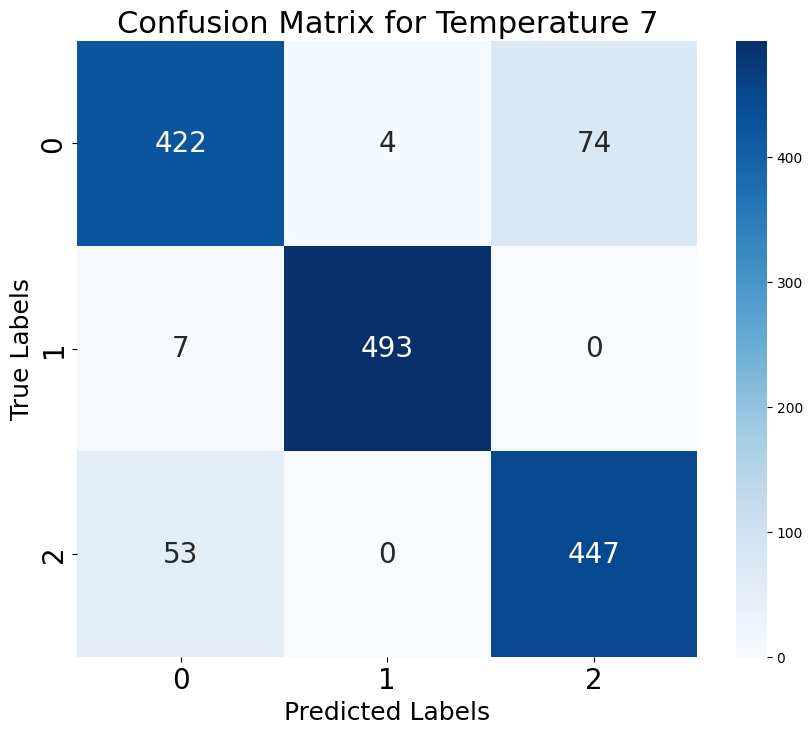

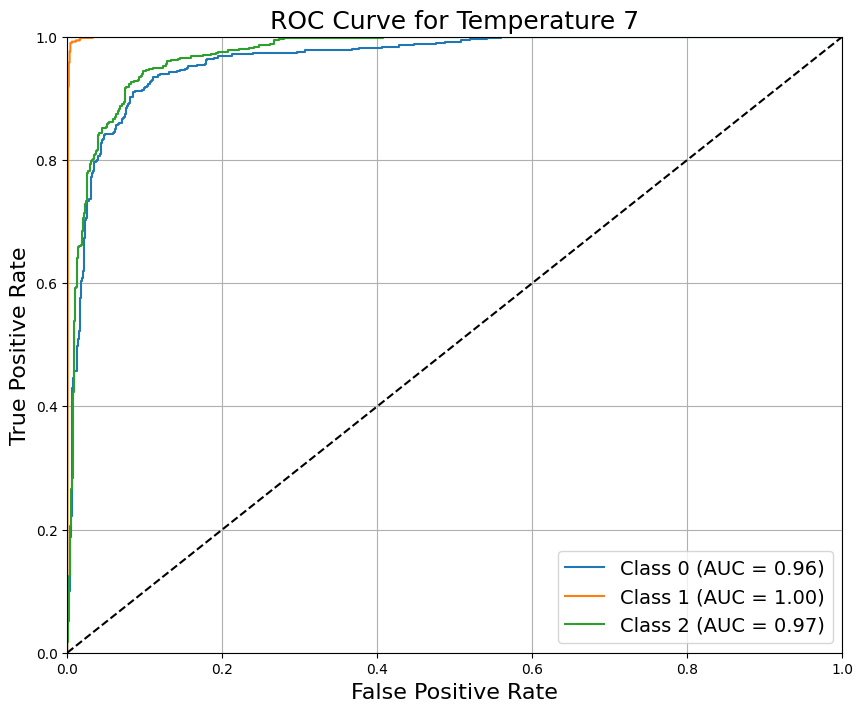

Training with temperature: 12
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1729956686.599099     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.6933 - loss: 0.0000e+00

W0000 00:00:1729956736.644839     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 598ms/step - accuracy: 0.6929 - loss: 0.0000e+00 - val_accuracy: 0.6587 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 566ms/step - accuracy: 0.7206 - loss: 0.0000e+00 - val_accuracy: 0.8387 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 575ms/step - accuracy: 0.8300 - loss: 0.0000e+00 - val_accuracy: 0.8140 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 566ms/step - accuracy: 0.8744 - loss: 0.0000e+00 - val_accuracy: 0.8273 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 559ms/step - accuracy: 0.8826 - loss: 0.0000e+00 - val_accuracy: 0.8847 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 571ms/step - accuracy: 0.9067 - loss: 0.0000e+00 - val_accuracy: 0.8860 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 582ms/step - accuracy: 0.9009 - loss: 0.0000e+00 - val_accuracy: 0.9047 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 580ms/step

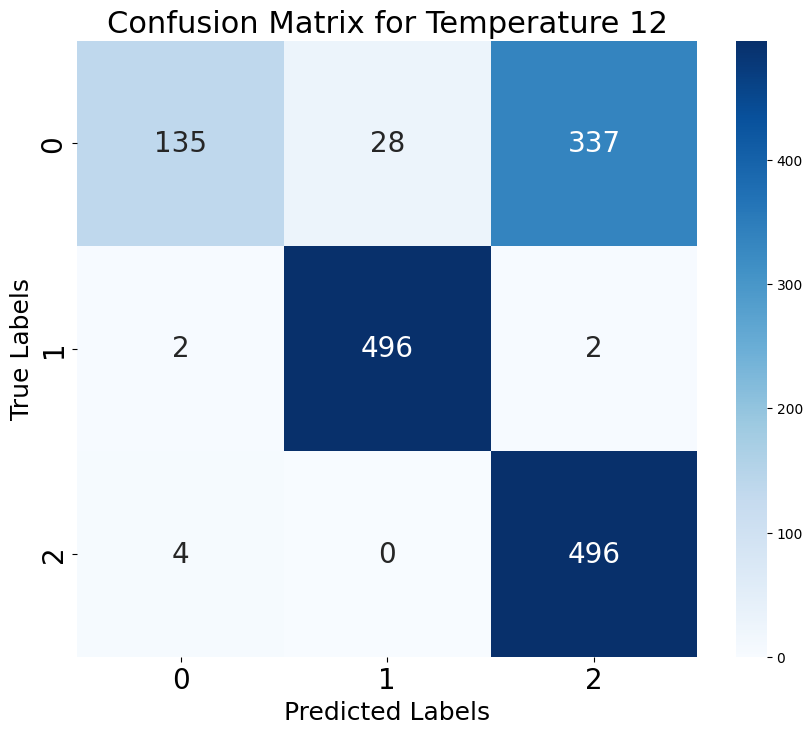

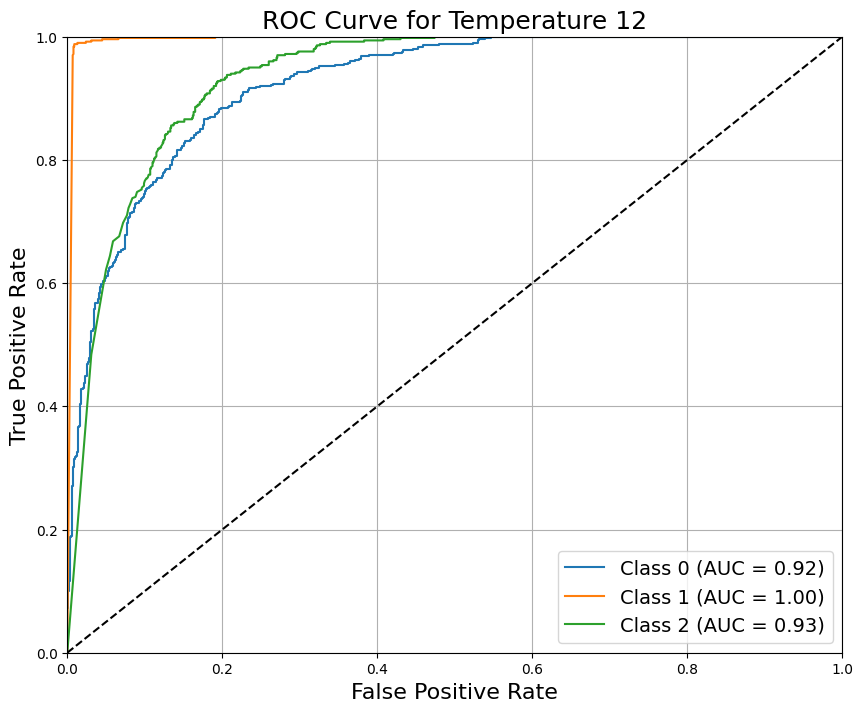

Training with temperature: 48
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1729957309.709883     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.6022 - loss: 0.0000e+00

W0000 00:00:1729957361.946416     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 68s 629ms/step - accuracy: 0.6030 - loss: 0.0000e+00 - val_accuracy: 0.6653 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 573ms/step - accuracy: 0.7444 - loss: 0.0000e+00 - val_accuracy: 0.8333 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 572ms/step - accuracy: 0.8680 - loss: 0.0000e+00 - val_accuracy: 0.9153 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 577ms/step - accuracy: 0.9154 - loss: 0.0000e+00 - val_accuracy: 0.9113 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 574ms/step - accuracy: 0.8822 - loss: 0.0000e+00 - val_accuracy: 0.8987 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 567ms/step - accuracy: 0.8857 - loss: 0.0000e+00 - val_accuracy: 0.8893 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 570ms/step - accuracy: 0.9275 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 572ms/step

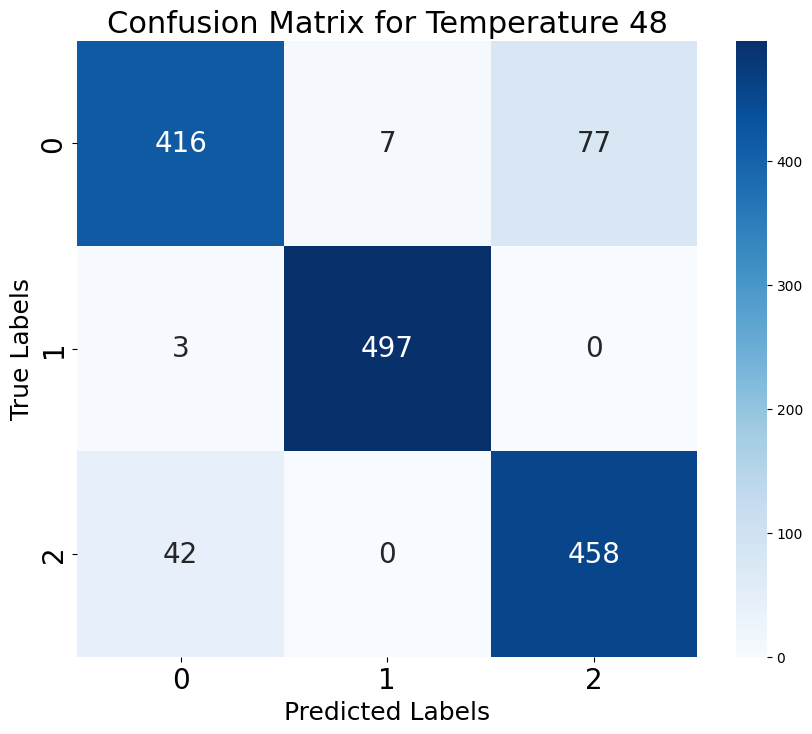

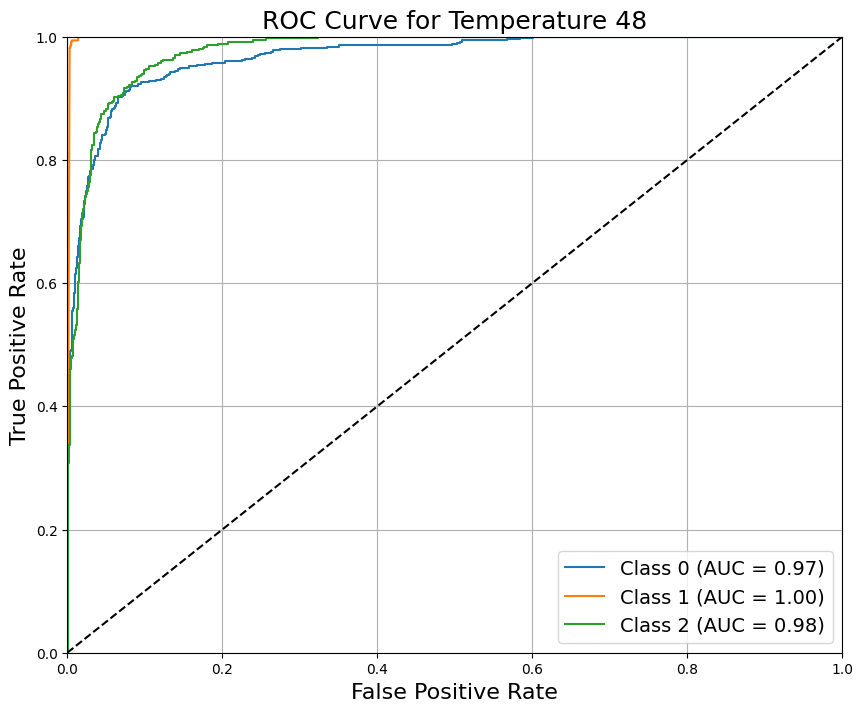

Training with temperature: 53
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1729957912.658889     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.5751 - loss: 0.0000e+00

W0000 00:00:1729957964.061936     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 619ms/step - accuracy: 0.5750 - loss: 0.0000e+00 - val_accuracy: 0.7873 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 577ms/step - accuracy: 0.7843 - loss: 0.0000e+00 - val_accuracy: 0.8400 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 570ms/step - accuracy: 0.8196 - loss: 0.0000e+00 - val_accuracy: 0.6453 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 583ms/step - accuracy: 0.6969 - loss: 0.0000e+00 - val_accuracy: 0.7627 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 579ms/step - accuracy: 0.7616 - loss: 0.0000e+00 - val_accuracy: 0.8280 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 575ms/step - accuracy: 0.8367 - loss: 0.0000e+00 - val_accuracy: 0.8607 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 567ms/step - accuracy: 0.8937 - loss: 0.0000e+00 - val_accuracy: 0.7900 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 587ms/step

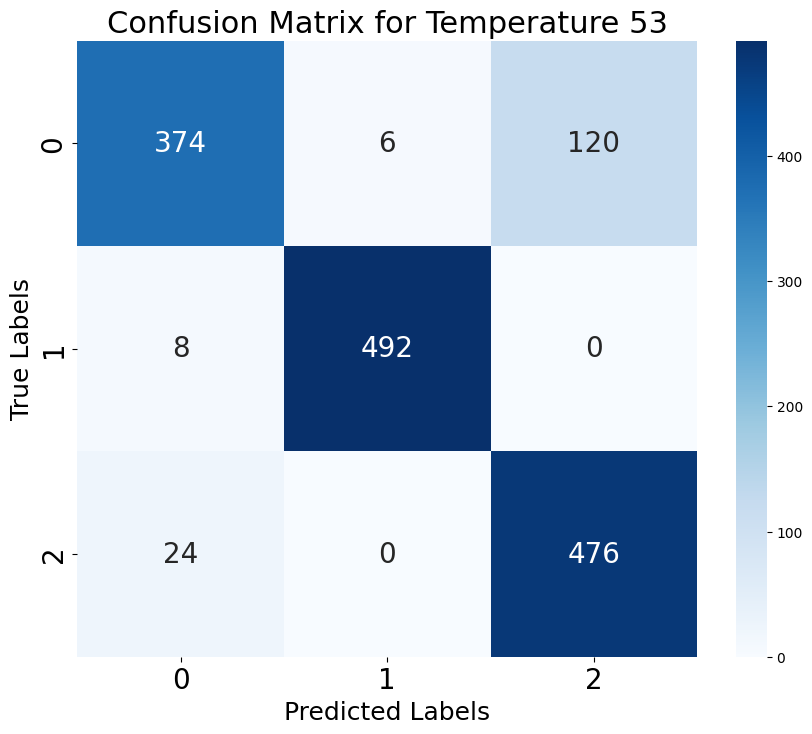

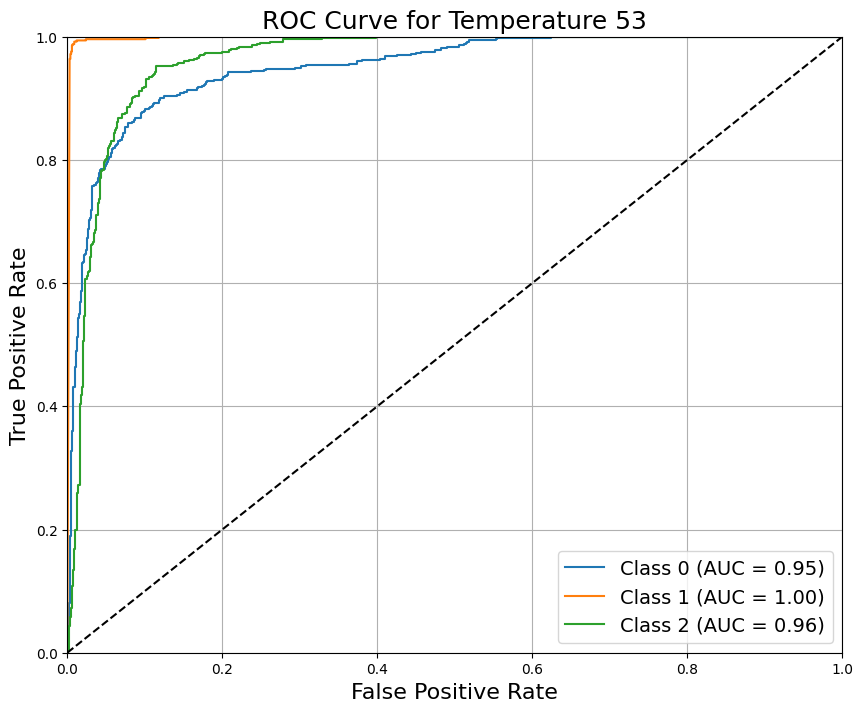

Training with temperature: 59
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1729958517.835526     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.5733 - loss: 0.0000e+00

W0000 00:00:1729958569.668720     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 68s 623ms/step - accuracy: 0.5740 - loss: 0.0000e+00 - val_accuracy: 0.7740 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 574ms/step - accuracy: 0.7099 - loss: 0.0000e+00 - val_accuracy: 0.7427 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 567ms/step - accuracy: 0.6675 - loss: 0.0000e+00 - val_accuracy: 0.6087 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 573ms/step - accuracy: 0.5839 - loss: 0.0000e+00 - val_accuracy: 0.6413 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 566ms/step - accuracy: 0.6377 - loss: 0.0000e+00 - val_accuracy: 0.7487 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 583ms/step - accuracy: 0.7857 - loss: 0.0000e+00 - val_accuracy: 0.7733 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 576ms/step - accuracy: 0.7842 - loss: 0.0000e+00 - val_accuracy: 0.7700 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 586ms/step

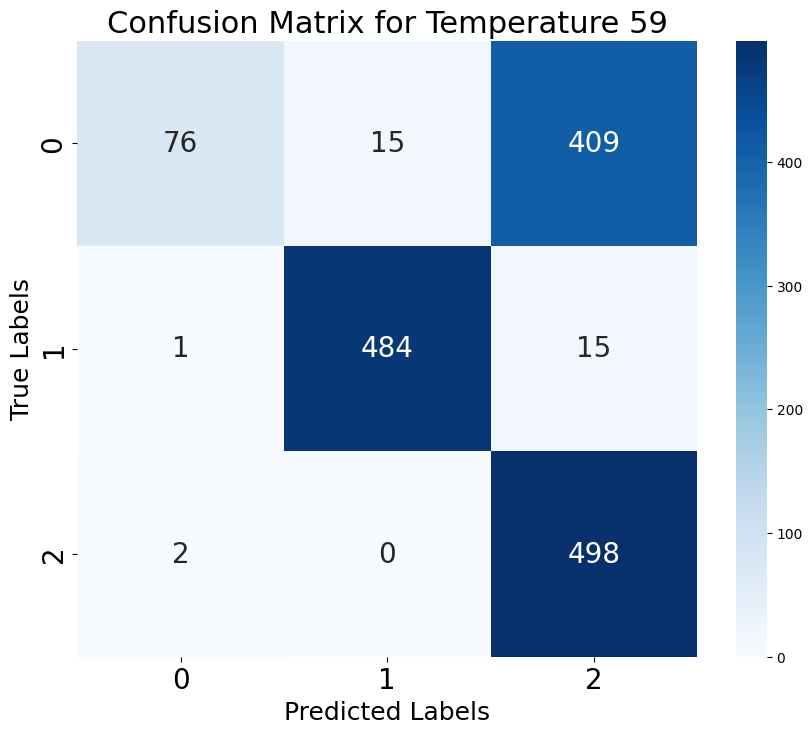

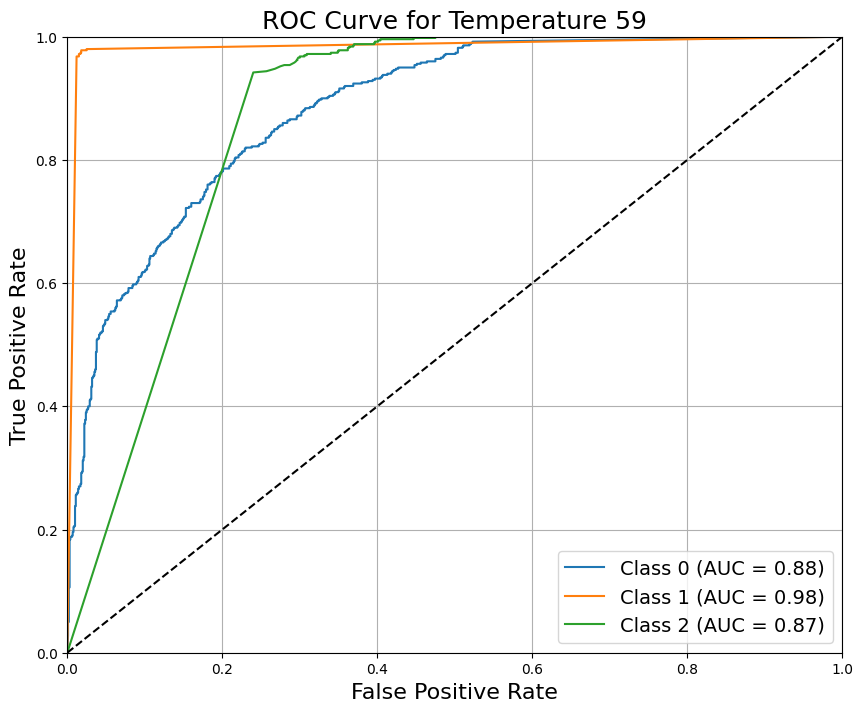

Training with temperature: 72
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1729959123.088843     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.5744 - loss: 0.0000e+00

W0000 00:00:1729959175.662034     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 68s 631ms/step - accuracy: 0.5751 - loss: 0.0000e+00 - val_accuracy: 0.8153 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 583ms/step - accuracy: 0.7806 - loss: 0.0000e+00 - val_accuracy: 0.7913 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 583ms/step - accuracy: 0.8182 - loss: 0.0000e+00 - val_accuracy: 0.7427 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 585ms/step - accuracy: 0.7975 - loss: 0.0000e+00 - val_accuracy: 0.6807 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 573ms/step - accuracy: 0.7281 - loss: 0.0000e+00 - val_accuracy: 0.8380 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 563ms/step - accuracy: 0.8686 - loss: 0.0000e+00 - val_accuracy: 0.8207 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 576ms/step - accuracy: 0.8114 - loss: 0.0000e+00 - val_accuracy: 0.8347 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 566ms/step

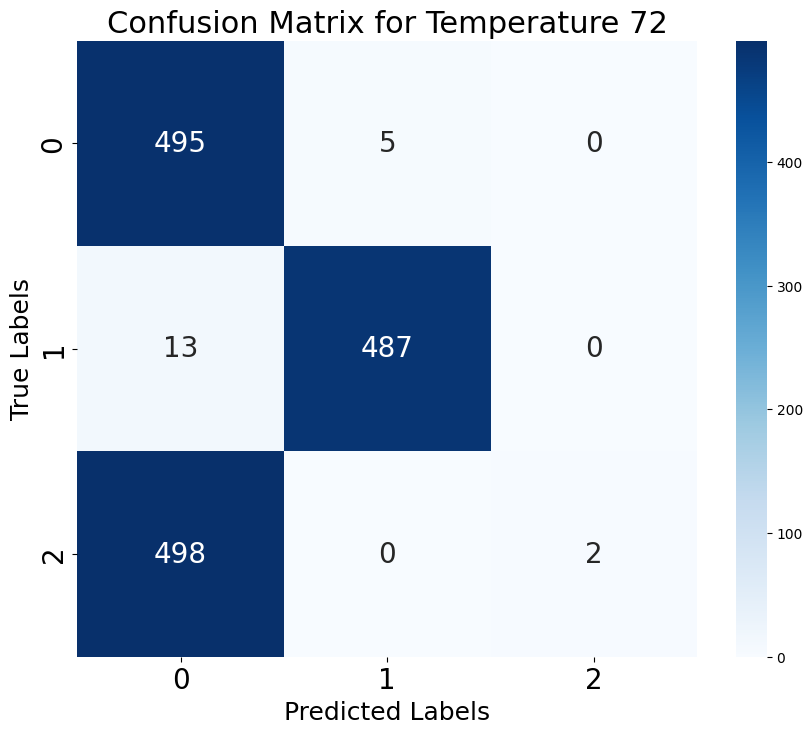

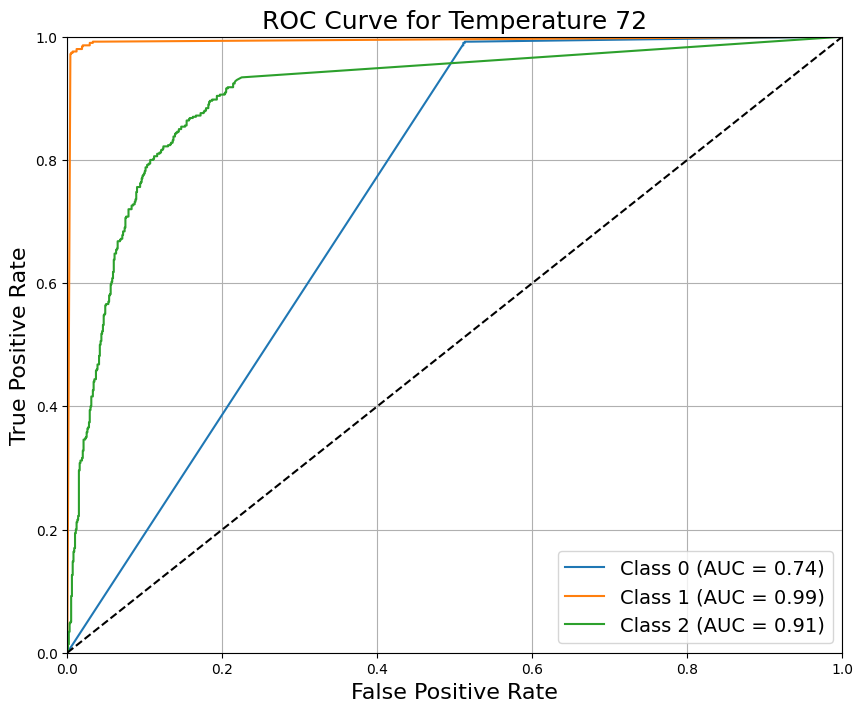

Training with temperature: 93
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1729959752.841678     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.6384 - loss: 0.0000e+00

W0000 00:00:1729959804.177663     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 618ms/step - accuracy: 0.6382 - loss: 0.0000e+00 - val_accuracy: 0.7187 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 584ms/step - accuracy: 0.6792 - loss: 0.0000e+00 - val_accuracy: 0.8267 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 571ms/step - accuracy: 0.7529 - loss: 0.0000e+00 - val_accuracy: 0.8440 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 575ms/step - accuracy: 0.8745 - loss: 0.0000e+00 - val_accuracy: 0.8000 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 576ms/step - accuracy: 0.8901 - loss: 0.0000e+00 - val_accuracy: 0.8347 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 582ms/step - accuracy: 0.8245 - loss: 0.0000e+00 - val_accuracy: 0.8520 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 576ms/step - accuracy: 0.8728 - loss: 0.0000e+00 - val_accuracy: 0.8480 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 576ms/step

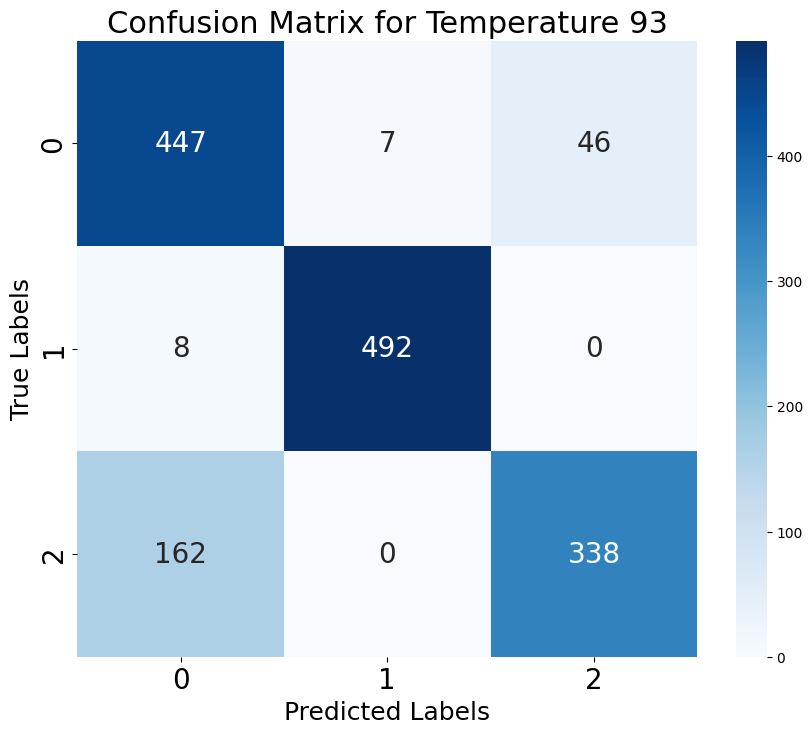

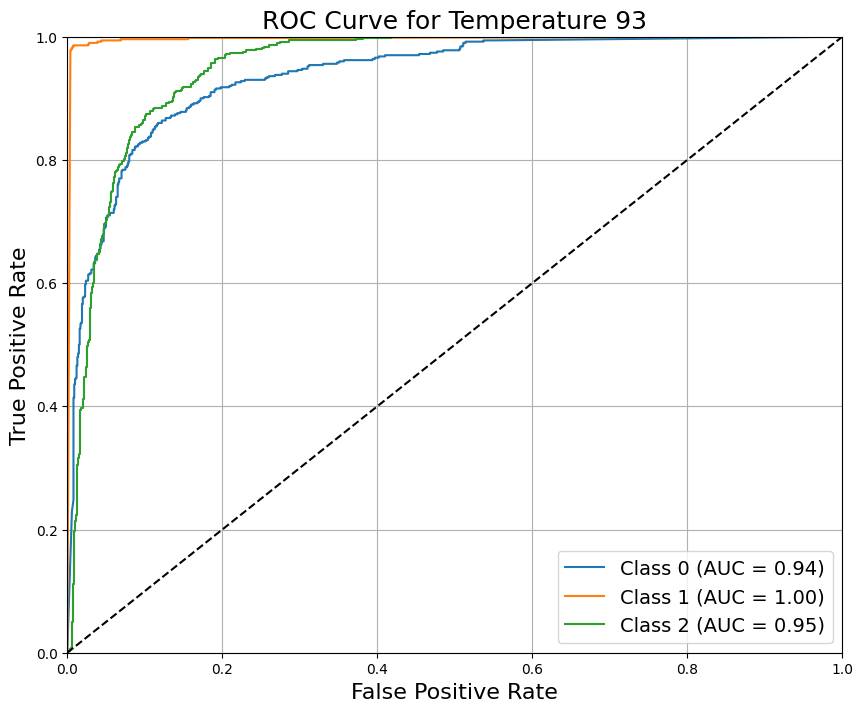

Training with temperature: 96
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1729960383.003018     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.6091 - loss: 0.0000e+00

W0000 00:00:1729960434.757999     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 68s 621ms/step - accuracy: 0.6097 - loss: 0.0000e+00 - val_accuracy: 0.6527 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 573ms/step - accuracy: 0.7202 - loss: 0.0000e+00 - val_accuracy: 0.8380 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 586ms/step - accuracy: 0.8674 - loss: 0.0000e+00 - val_accuracy: 0.8547 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 581ms/step - accuracy: 0.8714 - loss: 0.0000e+00 - val_accuracy: 0.8280 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 577ms/step - accuracy: 0.8820 - loss: 0.0000e+00 - val_accuracy: 0.8600 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 574ms/step - accuracy: 0.8893 - loss: 0.0000e+00 - val_accuracy: 0.8353 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 575ms/step - accuracy: 0.8519 - loss: 0.0000e+00 - val_accuracy: 0.8273 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 570ms/step

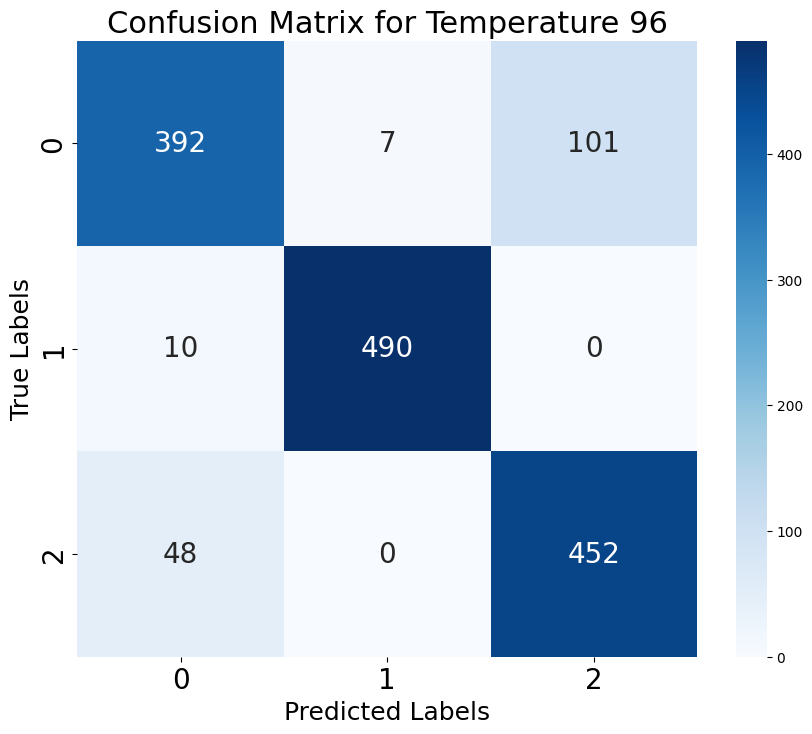

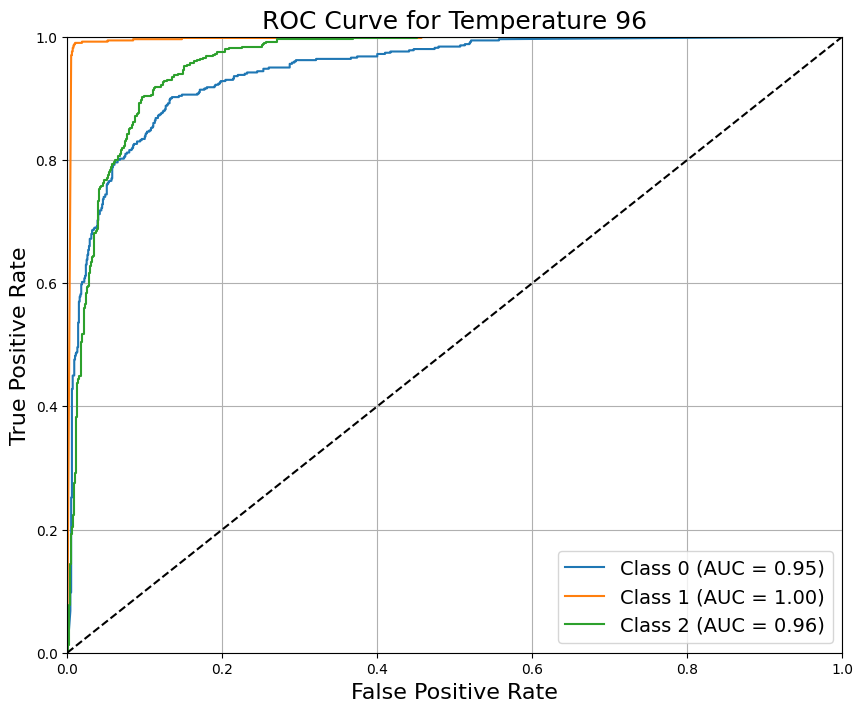

Training with temperature: 98
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1729960988.996812     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6155 - loss: 0.0000e+00

W0000 00:00:1729961041.013841     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 68s 625ms/step - accuracy: 0.6161 - loss: 0.0000e+00 - val_accuracy: 0.7900 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 583ms/step - accuracy: 0.7963 - loss: 0.0000e+00 - val_accuracy: 0.8493 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 569ms/step - accuracy: 0.8873 - loss: 0.0000e+00 - val_accuracy: 0.8673 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 569ms/step - accuracy: 0.9155 - loss: 0.0000e+00 - val_accuracy: 0.8447 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 572ms/step - accuracy: 0.9052 - loss: 0.0000e+00 - val_accuracy: 0.8700 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 581ms/step - accuracy: 0.8754 - loss: 0.0000e+00 - val_accuracy: 0.8413 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 571ms/step - accuracy: 0.8839 - loss: 0.0000e+00 - val_accuracy: 0.8367 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 568ms/step

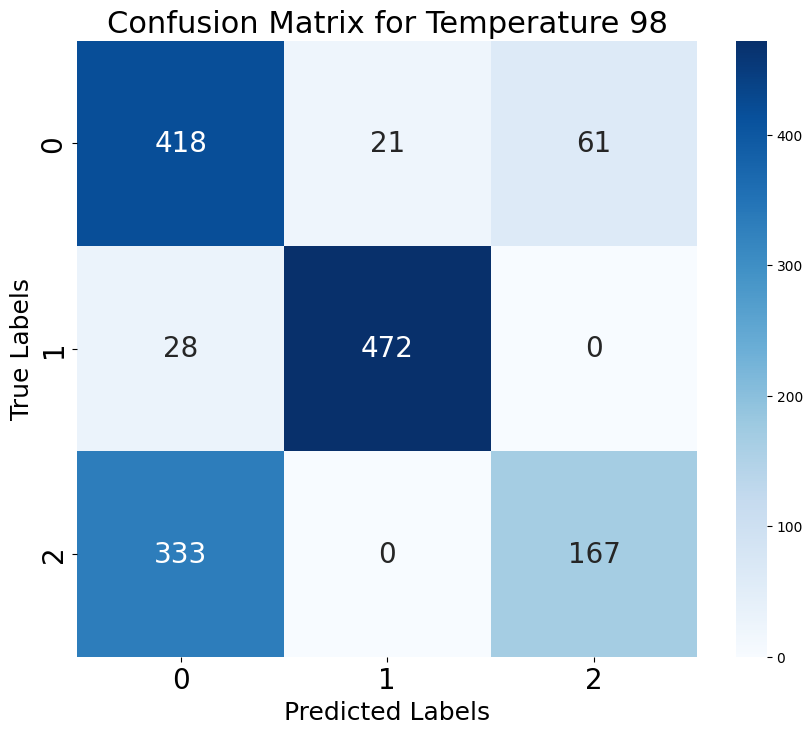

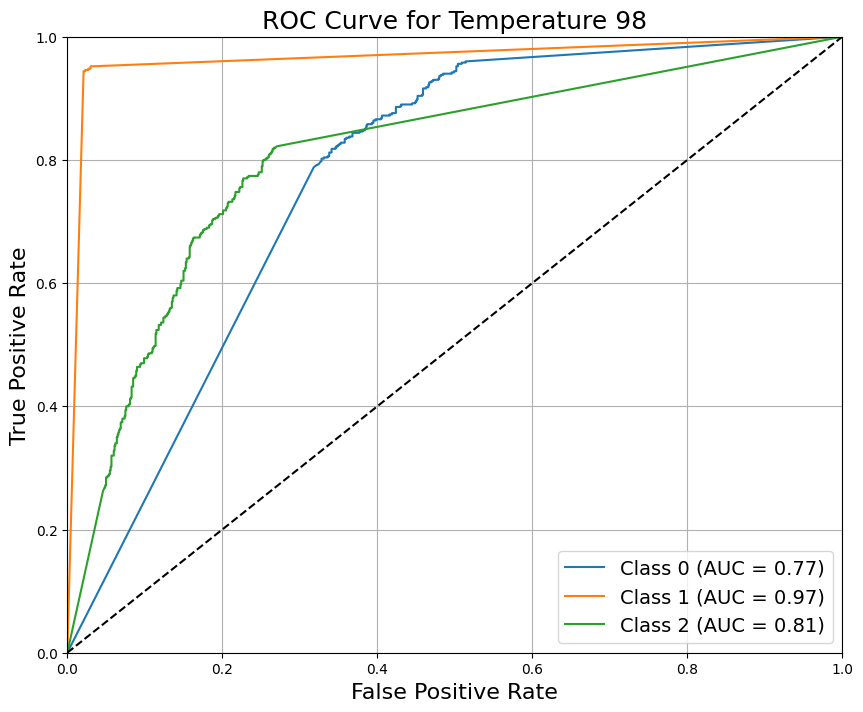

Training with temperature: 100
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1729961613.912785     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.6208 - loss: 0.0000e+00

W0000 00:00:1729961665.758368     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 68s 622ms/step - accuracy: 0.6212 - loss: 0.0000e+00 - val_accuracy: 0.7867 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 563ms/step - accuracy: 0.7325 - loss: 0.0000e+00 - val_accuracy: 0.7940 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 560ms/step - accuracy: 0.7326 - loss: 0.0000e+00 - val_accuracy: 0.7740 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 570ms/step - accuracy: 0.7242 - loss: 0.0000e+00 - val_accuracy: 0.8033 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 570ms/step - accuracy: 0.7663 - loss: 0.0000e+00 - val_accuracy: 0.7807 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 568ms/step - accuracy: 0.8621 - loss: 0.0000e+00 - val_accuracy: 0.8120 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 574ms/step - accuracy: 0.8287 - loss: 0.0000e+00 - val_accuracy: 0.8033 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 561ms/step

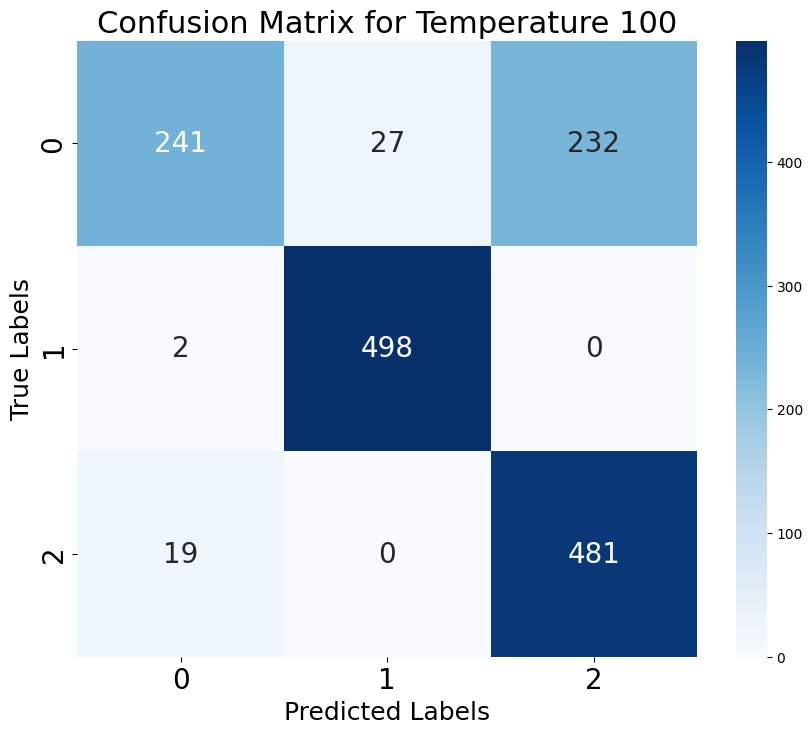

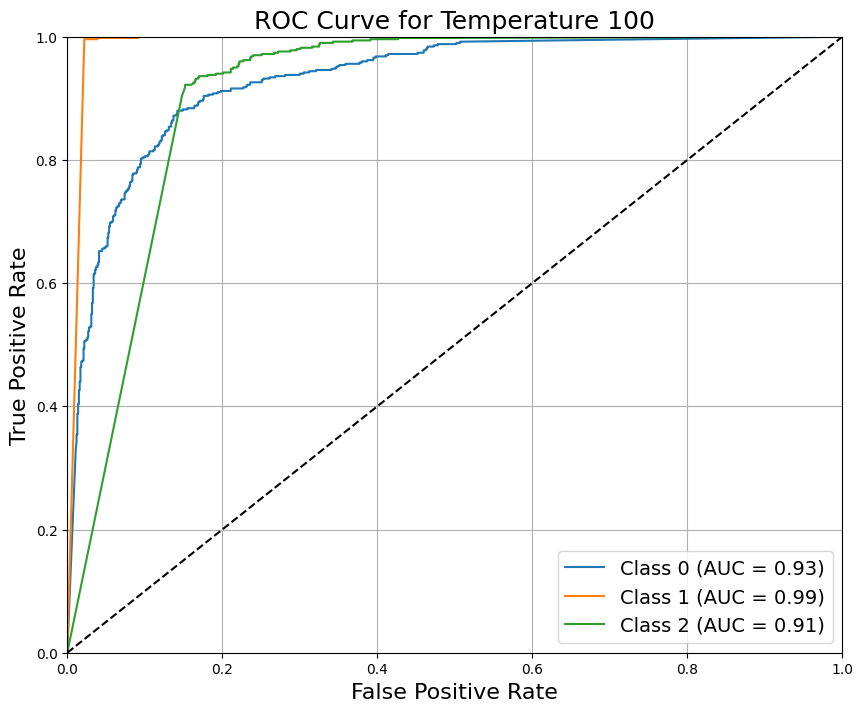

In [47]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

temperatures = [7,12,48,53,59,72,93,96,98,100]
results = []
num_classes = len(train_set.class_indices)

# Distiller model initialization
distiller_model1 = Distiller(student=model_1_kd, teacher=vgg16_model)

for temp in temperatures:
    print(f"Training with temperature: {temp}")
    
    distiller_model1.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['accuracy'],
        student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.3,
        temperature=temp
    )

    distiller_model1.fit(train_set, validation_data=validate_set, epochs=10, verbose=1)

    result = distiller_model1.evaluate(test_set, batch_size=128, verbose=0)
    test_accuracy = result[2]  

    y_pred = distiller_model1.predict(test_set, batch_size=128, verbose=0)
    y_true = test_set.labels  

    y_pred_classes = y_pred.argmax(axis=1)

    if len(y_true.shape) == 1:
        y_true_classes = y_true
    else:
        y_true_classes = y_true.argmax(axis=1)

    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    # Add Confusion Matrix and ROC Curve visualization
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.title(f'Confusion Matrix for Temperature {temp}', fontsize=22)
    plt.xlabel('Predicted Labels', fontsize=18)
    plt.ylabel('True Labels', fontsize=18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

    y_true_bin = label_binarize(y_true_classes, classes=list(range(num_classes)))

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(f'ROC Curve for Temperature {temp}', fontsize=18)
    plt.legend(loc='lower right', fontsize=14)
    plt.grid(True)
    plt.show()

    # Store the results
    results.append({
        'Alpha': 0.3,
        'Temperature': temp,
        'Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })


In [48]:
results_df = pd.DataFrame(results)
results_df

,Alpha,Temperature,Accuracy,Precision,Recall,F1 Score
0,0.3,7,0.908000,0.908479,0.908000,0.908017
1,0.3,12,0.751333,0.832675,0.751333,0.711013
2,0.3,48,0.914000,0.914857,0.914000,0.913610
3,0.3,53,0.894667,0.902597,0.894667,0.893397
4,0.3,59,0.705333,0.824032,0.705333,0.643971
5,0.3,72,0.656000,0.827295,0.656000,0.549064
6,0.3,93,0.851333,0.863551,0.851333,0.850016
7,0.3,96,0.889333,0.891462,0.889333,0.888904
8,0.3,98,0.704667,0.742148,0.704667,0.687694
9,0.3,100,0.813333,0.847678,0.813333,0.799109
